# Haciendo fine-tuning de DistilBERT para detectar spam en español

In [ ]:
!pip install datasets
!pip install transformers
!pip install evaluate
!pip install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, get_scheduler, TrainingArguments, Trainer
from torch.utils.data import DataLoader
import torch
import evaluate
import numpy as np
from tqdm.auto import tqdm
from accelerate import Accelerator
from torch.optim import AdamW
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# Descargamos el dataset en su totalidad
raw_dataset = load_dataset("Gabrielaz/spamspa")

raw_dataset["valid"] = raw_dataset["test"].train_test_split(test_size=0.9, seed=42)["test"]
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 4457
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1115
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1004
    })
})

In [ ]:
# Pre procesamos los datos

checkpoint = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

max_length = 256

def tokenize_function(examples):
    if isinstance(examples["text"], list):
        examples["text"] = [str(text) for text in examples["text"]]
    else:
        examples["text"] = str(examples["text"])
    return tokenizer(examples["text"],padding='max_length', truncation=True,max_length=max_length,return_tensors='pt')

tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

Map:   0%|          | 0/1004 [00:00<?, ? examples/s]

In [ ]:

# Creamos los dataloaders (Son para el entrenamiento manual)
train_dataloader = DataLoader(
    tokenized_dataset["train"], shuffle=True, batch_size=16, collate_fn=data_collator
)

test_dataloader = DataLoader(
    tokenized_dataset["test"], batch_size=16, collate_fn=data_collator
)

valid_dataloader = DataLoader(
    tokenized_dataset["valid"], batch_size=16, collate_fn=data_collator
)

# vamos a ver si el preprocesamiento funcionó bien
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([16]),
 'input_ids': torch.Size([16, 256]),
 'attention_mask': torch.Size([16, 256])}

In [ ]:
# Creamos las métricas de evaluación
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    f1_score = f1.compute(predictions=predictions, references=labels, average="weighted")
    return {
        "accuracy": acc["accuracy"],
        "f1": f1_score["f1"]
    }

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

training_args = TrainingArguments(
    output_dir="spam-detection-es",
    logging_dir="./logs",
    logging_strategy="epoch",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    push_to_hub=True,
  )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
entrenamiento = trainer.train()
entrenamiento

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.082400,0.061632,0.990040,0.989909
2,0.028100,0.068029,0.989044,0.988955
3,0.011500,0.063902,0.989044,0.989026


TrainOutput(global_step=1674, training_loss=0.04065460002265666, metrics={'train_runtime': 448.6021, 'train_samples_per_second': 29.806, 'train_steps_per_second': 3.732, 'total_flos': 885610793714688.0, 'train_loss': 0.04065460002265666, 'epoch': 3.0})

In [ ]:
# Visualizamos los resultados finales
test_results = trainer.evaluate(eval_dataset=tokenized_dataset["test"])
print(f"Resultados finales: {test_results}")

trainer.push_to_hub(commit_message = "Entrenamiento Completo")

Resultados finales: {'eval_loss': 0.06312752515077591, 'eval_accuracy': 0.989237668161435, 'eval_f1': 0.9890785315248329, 'eval_runtime': 7.963, 'eval_samples_per_second': 140.022, 'eval_steps_per_second': 17.581, 'epoch': 3.0}


CommitInfo(commit_url='https://huggingface.co/asfilcnx3/spam-detection-es/commit/c08c43b010af3588dde83611675cad3338b71dff', commit_message='Entrenamiento Completo', commit_description='', oid='c08c43b010af3588dde83611675cad3338b71dff', pr_url=None, repo_url=RepoUrl('https://huggingface.co/asfilcnx3/spam-detection-es', endpoint='https://huggingface.co', repo_type='model', repo_id='asfilcnx3/spam-detection-es'), pr_revision=None, pr_num=None)

## Entrenamiento Manual

In [ ]:
# Creamos el acelerador automático
accelerator = Accelerator()
print(accelerator.device)

# Creamos el modelo y sus métricas
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
optimizer = AdamW(model.parameters(), lr=3e-5)

# Pasamos por el aceleador lo necesario
train_dl, eval_dl, model, optimizer = accelerator.prepare(
    train_dataloader, test_dataloader, model, optimizer
)

num_epochs = 3
patience = 2
num_training_steps = num_epochs * len(train_dl)

lr_scheduler = get_scheduler(
    "linear",
    optimizer = optimizer,
    num_warmup_steps = 0,
    num_training_steps = num_training_steps,
)

# Barra de progreso y métrica
progress_bar = tqdm(range(num_training_steps))
acc_score = []
f1_score = []
best_accuracy = 0
counter = 0

# Bucle de entrenamiento
model.train()
for epoch in range(num_epochs):
  accuracy = evaluate.load("accuracy")
  f1 = evaluate.load("f1")
  for batch in train_dl:
    outputs = model(**batch)
    loss = outputs.loss
    accelerator.backward(loss)

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)

  # evaluación
  model.eval()
  for batch in eval_dl:
    with torch.no_grad():
      outputs = model(**batch)

      logits = outputs.logits
      predictions = torch.argmax(logits, dim=-1)
      accuracy.add_batch(predictions=accelerator.gather(predictions),
                       references=accelerator.gather(batch["labels"]))
      f1.add_batch(predictions=accelerator.gather(predictions),
                       references=accelerator.gather(batch["labels"]))


  acc_result = accuracy.compute()
  f1_result = f1.compute(average="weighted")
  acc_score.append(acc_result)
  f1_score.append(f1_result)
  accuracy_score = acc_result["accuracy"]
  if accuracy_score > best_accuracy:
    best_accuracy = accuracy_score
    counter = 0
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained("manual-spam-detection-es")
    tokenizer.save_pretrained("manual-spam-detection-es")

  else:
    counter += 1
    if counter > patience:
      print("Early stopping triggered")
      break


  print(f"Epoch: {epoch+1} -> Accuracy: {acc_result['accuracy']:.4f}, F1: {f1_result['f1']:.4f}")
  print("----" * 20)

cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/837 [00:00<?, ?it/s]

Epoch: 1 -> Accuracy: 0.9848, F1: 0.9848
--------------------------------------------------------------------------------
Epoch: 2 -> Accuracy: 0.9865, F1: 0.9866
--------------------------------------------------------------------------------
Epoch: 3 -> Accuracy: 0.9892, F1: 0.9891
--------------------------------------------------------------------------------


In [ ]:
# Mandar al hub el mejor modelo
manual_model = AutoModelForSequenceClassification.from_pretrained("manual-spam-detection-es")
manual_tokenizer = AutoTokenizer.from_pretrained("manual-spam-detection-es")

repo_id = "asfilcnx3/manual-spam-detection-es"
manual_model.push_to_hub(repo_id = repo_id, commit_message = "Primer entrenamiento manual")
manual_tokenizer.push_to_hub(repo_id = repo_id, commit_message = "Primer entrenamiento manual")

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/asfilcnx3/manual-spam-detection-es/commit/a88bd756eb196b4a92b5d99f170f5197a1712cbd', commit_message='Primer entrenamiento manual', commit_description='', oid='a88bd756eb196b4a92b5d99f170f5197a1712cbd', pr_url=None, repo_url=RepoUrl('https://huggingface.co/asfilcnx3/manual-spam-detection-es', endpoint='https://huggingface.co', repo_type='model', repo_id='asfilcnx3/manual-spam-detection-es'), pr_revision=None, pr_num=None)

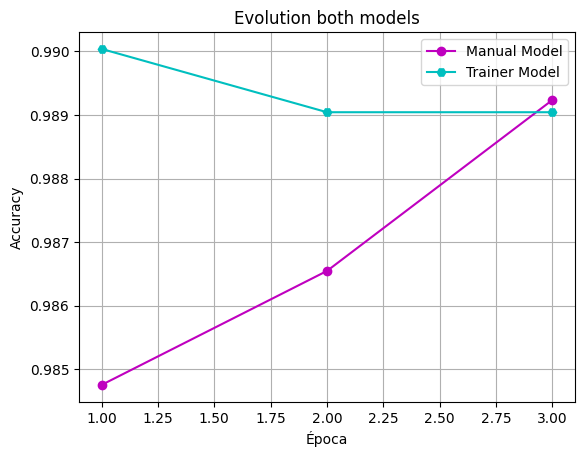

In [ ]:
# Visualizamos las diferencias entre el entrenamiento de ambos modelos
acc_manual = [m["accuracy"] for m in acc_score]
acc_train = [0.990040, 0.989044, 0.989044]
plt.plot(range(1, num_epochs+1), acc_manual, marker='o', c="m")
plt.plot(range(1, num_epochs+1), acc_train, marker='H', c="c")
plt.title("Evolution both models")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend(["Manual Model", "Trainer Model"])
plt.grid()
plt.show()

In [ ]:
# Cargar mejor modelo y comparar entre los entrenamientos
model.eval()
test_dl = accelerator.prepare(test_dataloader)
test_accuracy = evaluate.load("accuracy")
test_f1 = evaluate.load("f1")
test_loss = []

for batch in test_dl:
    with torch.no_grad():
        outputs = model(**batch)
        predictions = torch.argmax(outputs.logits, dim=-1)
        test_loss.append(outputs.loss.item())
        test_accuracy.add_batch(predictions=accelerator.gather(predictions),
                                references=accelerator.gather(batch["labels"]))
        test_f1.add_batch(predictions=accelerator.gather(predictions),
                          references=accelerator.gather(batch["labels"]))

print("Manual Model Test Set Results:")
print(f"Accuracy: {test_accuracy.compute()['accuracy']:.3f}")
print(f"F1 score: {test_f1.compute(average='weighted')['f1']:.3f}")
print(f"Loss: {(test_loss[-1]):.3f}")

print("Trainer Model Test Set Results:")
print(f"Accuracy: {test_results['eval_accuracy']:.3f}")
print(f"F1 score: {test_results['eval_f1']:.3f}")
print(f"Loss: {test_results['eval_loss']:.3f}")

Manual Model Test Set Results:
Accuracy: 0.989
F1 score: 0.989
Loss: 0.002
Trainer Model Test Set Results:
Accuracy: 0.989
F1 score: 0.989
Loss: 0.063
